In [1]:
import os, sys
import re
import pandas as pd
import numpy as np
import itertools
import gluonnlp as nlp
from nltk.tokenize import WhitespaceTokenizer
from collections import Counter
import tensorflow as tf
import keras
from keras.preprocessing.sequence import pad_sequences
from pprint import pprint
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
col_name = ['itme_SEQ', 'category_SEQ', 'company_SEQ', 'price', 'item_name', 'brand_name', 'maker_name', 'cateL',
            'cateM', 'cateS','cateD']

In [3]:
train_data = pd.read_csv('./ProductCategoryAutoMatching/data_small/train.tsv', header=None, delimiter='\t',names=col_name, index_col=None )
train_data.fillna('', inplace=True)

In [4]:
valid_data = pd.read_csv('./ProductCategoryAutoMatching/data_small/valid.tsv', header=None, delimiter='\t',names=col_name, index_col=None )
valid_data.fillna('', inplace=True)

In [5]:
test_data = pd.read_csv('./ProductCategoryAutoMatching/data_small/test.tsv', header=None, delimiter='\t',names=col_name, index_col=None )
test_data.fillna('', inplace=True)

### Preprocessing

In [6]:
#preprocessing
# feature들 다 합침.
ws_tok = WhitespaceTokenizer()

def preprocessing(item_name, brand_name, maker_name, cateL, cateM, cateS, cateD):
    if len(item_name) == 0: item_name = ''
    elif len(brand_name) == 0: brand_name = ''
    elif len(maker_name) == 0: maker_name = ''
    elif len(cateL) == 0: cateL = ''
    elif len(cateM) == 0: cateM = ''
    elif len(cateS) == 0: cateS = ''
    elif len(cateD) == 0: cateD = ''
    
    new_name = re.sub("[^가-힣]", ' ', item_name+' '+brand_name+' '+maker_name+' '+cateL+' '+cateM
                     +' '+cateS+' '+cateD)
    new_name = list(set(ws_tok.tokenize(new_name)))
    return new_name

# def one_hot(dataset):
#     indices = [0, 1, 2]
# depth = 3
# tf.one_hot(indices, depth)

#      category_one_hot = tf.one_hot(dataset.category_SEQ, )
    
def feature_concat(dataset):
    features = []
    item = dataset.item_name
    brand = dataset.brand_name
    maker = dataset.maker_name
    cateL = dataset.cateL
    cateM = dataset.cateM
    cateS = dataset.cateS
    cateD = dataset.cateD

    for i in range(1, len(dataset)):
        features.append(preprocessing(item[i], brand[i], maker[i], cateL[i], cateM[i], cateS[i], cateD[i]))
    return features

In [7]:
# train, validation, test set 
tr_data = feature_concat(train_data) 
val_data = feature_concat(valid_data)
tst_data = feature_concat(test_data)

### Building vocabulary and connecting vocabulary with fasttext embedding  

In [8]:
#vocab using gluonnlp, fasttext 
counter = nlp.data.count_tokens(itertools.chain.from_iterable([c for c in tr_data]))
vocab = nlp.Vocab(counter,bos_token=None, eos_token=None, min_freq=1)

# Loading fasttext embedding 
fasttext_simple = nlp.embedding.create('fasttext', source='wiki.ko')
# vocab에 fasttest붙여줌
vocab.set_embedding(fasttext_simple)

In [9]:
embed = vocab.embedding.idx_to_vec.asnumpy()
initial_shape = embed.shape[0]

### Word embedding of X 

In [39]:
def embedding(dataset):
    #vocab.embedding.idx_to_vec
    token2idx = list(map(lambda sen: [vocab.token_to_idx[token] for token in sen], dataset))
    token2idx = pad_sequences(sequences=token2idx, maxlen=300, padding='post', truncating='post', value=1)
    return token2idx #type: np.ndarray

print('embedding func')

embedding func


In [11]:
X_tr = embedding(tr_data)
y_tr = list(elm-1 for elm in train_data.category_SEQ[1:])

In [12]:
X_val = embedding(val_data)
y_val = list(elm-1 for elm in valid_data.category_SEQ[1:])

In [ ]:
X_tst = 

In [40]:
X_tst = embedding(tst_data)
y_tst = list(elm-1 for elm in test_data.category_SEQ[1:])

In [41]:
X_tst.shape

(21718, 300)

### Modeling 

In [14]:
class MorphConv:
    def __init__(self, X, y, n_of_classes, embedding):
        
        with tf.variable_scope('input_layer'):
            self.__X = X
            self.__y = y
            self.is_training = tf.placeholder(dtype = tf.bool)
        
        with tf.variable_scope('embedding_layer'): # Mulit-channel 구현(Static-channel, Non-static channel)
            static_embed = tf.get_variable(name = 'static', initializer = embedding,
                                           trainable = False) # static이라서 word vector training 안시킴 
            non_static_embed = tf.get_variable(name = 'non_static', initializer = embedding,
                                               trainable = True) # non-static이라서 word vector training 시킴 
#             print(static_embed)
            static_batch = tf.nn.embedding_lookup(params = static_embed, ids = self.__X)
            non_static_batch = tf.nn.embedding_lookup(params = non_static_embed, ids = self.__X)
            
        with tf.variable_scope('convoluion_layer'):
            with tf.variable_scope('tri_gram'): #token을 3개씩 봄
                
                tri_gram = keras.layers.Conv1D(filters = 100, kernel_size = 3, 
                                               activation = keras.activations.relu,
                                               kernel_initializer = 'he_uniform', padding = 'valid')
                static_3 = tri_gram(static_batch)
                non_static_3 = tri_gram(non_static_batch)
            
            with tf.variable_scope('tetra_gram'): #token을 4개씩 봄
                tetra_gram = keras.layers.Conv1D(filters = 100, kernel_size = 4,
                                                 activation = keras.activations.relu,
                                                 kernel_initializer = 'he_uniform', padding = 'valid')
                
                static_4 = tetra_gram(static_batch)
                non_static_4 = tetra_gram(non_static_batch)
            
            with tf.variable_scope('penta_gram'): #token을 5개씩 봄
                penta_gram = keras.layers.Conv1D(filters = 100, kernel_size = 5,
                                                 activation = keras.activations.relu,
                                                 kernel_initializer = 'he_uniform', padding = 'valid')
                
                static_5 = penta_gram(static_batch)
                non_static_5 = penta_gram(non_static_batch)
            
            # Max over time pooling
            fmap_3 = tf.reduce_max(static_3 + non_static_3, axis = 1)
            fmap_4 = tf.reduce_max(static_4 + non_static_4, axis = 1)
            fmap_5 = tf.reduce_max(static_5 + non_static_5, axis = 1)
            
        with tf.variable_scope('output_layer'):
            flattened = tf.concat([fmap_3, fmap_4, fmap_5], axis = -1)
            score = keras.layers.Dense(units = n_of_classes,
                                       kernel_regularizer = keras.regularizers.l2(.7))(flattened)
            
            self.__score = keras.layers.Dropout(rate = .5)(score, training = self.is_training)

        with tf.variable_scope('loss'):
            ce_loss = tf.losses.sparse_softmax_cross_entropy(labels = self.__y, logits = self.__score)
            reg_term = tf.reduce_sum(tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES))
            self.total_loss = ce_loss + reg_term
        
        with tf.variable_scope('prediction'):
            self.prediction = tf.argmax(self.__score, axis = -1)
        
    # predict instance method for small dataset
    
    def predict(self, sess, x_data, is_training = False):
        feed_prediction = {self.__X : x_data, self.is_training : is_training}
        return sess.run(self.prediction, feed_dict = feed_prediction)

In [15]:
# hyper-parameter
lr = .003
epochs = 5
batch_size = 500
total_step = int(X_tr.shape[0] / batch_size)
print(total_step)

343


In [16]:
# train
tr_dataset = tf.data.Dataset.from_tensor_slices((X_tr, y_tr))
tr_dataset = tr_dataset.shuffle(buffer_size = 1000000)
tr_dataset = tr_dataset.batch(batch_size = batch_size)
tr_iterator = tr_dataset.make_initializable_iterator()

In [17]:
# val
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.batch(batch_size = batch_size)
val_iterator = val_dataset.make_initializable_iterator()

In [18]:
# anonymous iterator
handle = tf.placeholder(dtype = tf.string)
iterator = tf.data.Iterator.from_string_handle(string_handle = handle,
                                               output_types = tr_iterator.output_types,
                                               output_shapes = tr_iterator.output_shapes)
x_data, y_data = iterator.get_next()

In [19]:
morph_conv = MorphConv(X = x_data, y = y_data, n_of_classes = 11,
                       embedding = vocab.embedding.idx_to_vec.asnumpy())

In [20]:
# create training op
opt = tf.train.AdamOptimizer(learning_rate = lr)
training_op = opt.minimize(loss = morph_conv.total_loss)

### Training 

In [21]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
tr_handle, val_handle = sess.run(fetches = [tr_iterator.string_handle(), val_iterator.string_handle()])

In [22]:
tr_loss_hist = []
val_loss_hist = []

for epoch in tqdm(range(epochs)):

    avg_tr_loss = 0
    avg_val_loss = 0
    tr_step = 0
    val_step = 0

    # for mini-batch training
    sess.run(tr_iterator.initializer)    
    try:
        
        while True:
            _, tr_loss = sess.run(fetches = [training_op, morph_conv.total_loss],
                                             feed_dict = {handle : tr_handle, morph_conv.is_training : True})
            avg_tr_loss += tr_loss
            tr_step += 1

    except tf.errors.OutOfRangeError:
        pass

    # for validation
    sess.run(val_iterator.initializer)
    try:
        while True:
            val_loss = sess.run(fetches = morph_conv.total_loss,
                                feed_dict = {handle : val_handle, morph_conv.is_training : False})
            avg_val_loss += val_loss
            val_step += 1
    
    except tf.errors.OutOfRangeError:
        pass

    avg_tr_loss /= tr_step
    avg_val_loss /= val_step
    tr_loss_hist.append(avg_tr_loss)
    val_loss_hist.append(avg_val_loss)
    
    print('epoch : {:3}, tr_loss : {:.3f}, val_loss : {:.3f}'.format(epoch + 1, avg_tr_loss, avg_val_loss))

 20%|██        | 1/5 [03:30<14:01, 210.29s/it]

epoch :   1, tr_loss : 1.743, val_loss : 0.952


 40%|████      | 2/5 [06:59<10:30, 210.02s/it]

epoch :   2, tr_loss : 1.434, val_loss : 0.848


 60%|██████    | 3/5 [10:30<07:00, 210.34s/it]

epoch :   3, tr_loss : 1.326, val_loss : 0.770


 80%|████████  | 4/5 [14:01<03:30, 210.36s/it]

epoch :   4, tr_loss : 1.256, val_loss : 0.771


100%|██████████| 5/5 [17:31<00:00, 210.24s/it]

epoch :   5, tr_loss : 1.213, val_loss : 0.788


### Test 

In [23]:
tst_dataset = tf.data.Dataset.from_tensor_slices((X_tst, y_tst))
tst_dataset = tst_dataset.batch(batch_size = batch_size)
tst_iterator = tst_dataset.make_initializable_iterator()

In [24]:
tst_handle = sess.run(tst_iterator.string_handle())

In [25]:
y_tst_hat = np.array([])

sess.run(tst_iterator.initializer)

try:
    while True:
        y_tst_tmp = sess.run(morph_conv.prediction,
                            feed_dict = {handle : tst_handle,
                                         morph_conv.is_training : False})
        y_tst_hat= np.append(y_tst_hat,y_tst_tmp)

except tf.errors.OutOfRangeError:
    pass

In [26]:
print('test acc : {:.2%}'.format(np.mean(y_tst_hat == np.array(y_tst))))

test acc : 74.22%


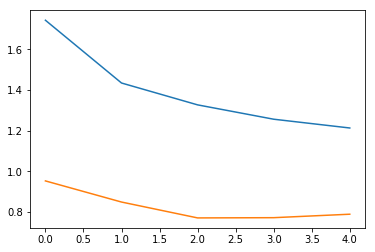

In [27]:
plt.plot(tr_loss_hist, label = 'train')
plt.plot(val_loss_hist, label = 'validation')
plt.show()

### Save model
- saver.save(sess=sess, save_path=path) 
- 모델 인스턴스 생성(weight x)
- saver.restore(sess, save_path) --> (weight o)

In [28]:
val_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)

In [29]:
saver = tf.train.Saver(var_list=val_list)

In [30]:
saver.save(sess= sess, save_path = './cnn_model_9/')

'./cnn_model_9/'

In [31]:
sess.close()

In [32]:
tf.reset_default_graph()

In [33]:
x_data_infer = tf.placeholder(dtype = tf.int32, shape = [None, 300]) # 300은 sequence의 max_length
y_data_infer = tf.placeholder(dtype = tf.int32, shape = [None]) 

In [34]:
initial = np.zeros(shape = [initial_shape,300], dtype = np.float32)

In [35]:
morph_conv_infer = MorphConv(X = x_data_infer, y = y_data_infer, n_of_classes = 11,
                             embedding = initial)

In [36]:
#restore model 
sess = tf.Session()
saver = tf.train.Saver()
saver.restore(sess = sess , save_path =  './cnn_model_9/')

INFO:tensorflow:Restoring parameters from ./cnn_model_9/


INFO:tensorflow:Restoring parameters from ./cnn_model_9/


In [42]:
y_tst_hat = morph_conv_infer.predict(sess = sess, x_data = X_tst[:10])

In [43]:
y_tst_hat

array([5, 7, 5, 5, 5, 2, 5, 1, 4, 7])

In [44]:
y_tst[:10]

[5, 5, 5, 5, 5, 5, 5, 5, 5, 5]